In [1804]:
import numpy as np
!pip install opencv-python
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

In [1805]:
"""from google.colab import drive
drive.mount('/content/drive')"""


"from google.colab import drive\ndrive.mount('/content/drive')"

In [1806]:
%cd /content/drive/MyDrive/final_depth_densification

[Errno 2] No such file or directory: '/content/drive/MyDrive/final_depth_densification'
/media/litis/T5 EVO2/test


In [1807]:
import numpy as np
import numpy as np


def create_label_colormap():
    """Creates a label colormap used in CITYSCAPES segmentation benchmark."""
    
    palette = [
        [165,42,42],[0,192,0],[196,196,196],[190,153,153],[180,165,180],
        [90,120,150],[102,102,156],[128,64,255],[140,140,200],[170,170,170],
        [250,170,160],[96,96,96],[230,150,140],[128,64,128],[110,110,110],
        [244,35,232],[150,100,100],[70,70,70],[150,120,90],[220,20,60],
        [255,0,0],[255,0,100],[255,0,200],[200,128,128],[255,255,255],
        [64,170,64],[230,160,50],[70,130,180],[190,255,255],[152,251,152],
        [107,142,35],[0,170,30],[255,255,128],[250,0,30],[100,140,180],
        [220,220,220],[220,128,128],[222,40,40],[100,170,30],[40,40,40],
        [33,33,33],[100,128,160],[142,0,0],[70,100,150],[210,170,100],
        [153,153,153],[128,128,128],[0,0,80],[250,170,30],[192,192,192],
        [220,220,0],[140,140,20],[119,11,32],[150,0,255],[0,60,100],
        [0,0,142],[0,0,90],[0,0,230],[0,80,100],[128,64,64],[0,0,110],
        [0,0,70],[0,0,192],[32,32,32],[120,10,10],
    ]

    colormap = np.zeros((256, 3), dtype=np.uint8)
    for i, color in enumerate(palette):
        colormap[i] = color

    return colormap

# Keep original name
LABEL_NAMES = np.asarray([
    'Bird','Ground Animal','Curb','Fence','Guard Rail','Barrier','Wall',
    'Bike Lane','Crosswalk - Plain','Curb Cut','Parking','Pedestrian Area',
    'Rail Track','Road','Service Lane','Sidewalk','Bridge','Building','Tunnel',
    'Person','Bicyclist','Motorcyclist','Other Rider','Lane Marking - Crosswalk',
    'Lane Marking - General','Mountain','Sand','Sky','Snow','Terrain',
    'Vegetation','Water','Banner','Bench','Bike Rack','Billboard','Catch Basin',
    'CCTV Camera','Fire Hydrant','Junction Box','Mailbox','Manhole','Phone Booth',
    'Pothole','Street Light','Pole','Traffic Sign Frame','Utility Pole',
    'Traffic Light','Traffic Sign (Back)','Traffic Sign (Front)','Trash Can',
    'Bicycle','Boat','Bus','Car','Caravan','Motorcycle','On Rails',
    'Other Vehicle','Trailer','Truck','Wheeled Slow','Car Mount','Ego Vehicle',
])

# Map 66-class indices → 15 reduced-class indices
# Note: classes not explicitly listed will be assumed 'Void' (0)
REDUCED_LABEL_MAPPING = np.zeros(256, dtype=np.uint8)

# Manually define grouped indices
groups = {
    1: [13, 14, 15, 7, 8, 9, 10, 11, 12, 24],              # Flat
    2: [3, 4, 5, 6, 16, 17, 18],                           # Construction
    3: [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 48],       # Object
    4: [30],                                               # Vegetation
    5: [27],                                               # Sky
    6: [49, 50, 51, 52, 53, 54, 55, 56, 57, 58],           # Vehicle
    7: [19, 20, 21, 22],                                   # Dynamic (people/riders)
    8: [31],                                               # Water
    9: [28, 29],                                           # Terrain (snow, terrain)
    10: [45, 46, 47],                                      # Signage
    11: [33, 34],                                          # Furniture
    12: [2],                                               # Barrier
    13: [0, 1],                                            # Animal
    14: [59],                                              # Ego Vehicle
    0: [23, 25, 26, 32, 60, 61, 62, 63, 64, 65],           # Void & undefined
}

for class_id, indices in groups.items():
    for idx in indices:
        REDUCED_LABEL_MAPPING[idx] = class_id

# 2) Number of reduced classes (max + 1)
num_reduced_classes = REDUCED_LABEL_MAPPING.max() + 1

# 3) Initialize reduced colormap array
reduced_colormap = np.zeros((num_reduced_classes, 3), dtype=np.uint8)

# 4) For each reduced class, pick first original color mapped to it
for reduced_class in range(num_reduced_classes):
    # Get all original class indices mapping to this reduced class
    orig_class_indices = np.where(REDUCED_LABEL_MAPPING == reduced_class)[0]
    if len(orig_class_indices) == 0:
        # No original class maps here → black
        reduced_colormap[reduced_class] = [0, 0, 0]
    else:
        # Pick first original class color
        colormap=create_label_colormap()
        reduced_colormap[reduced_class] = colormap[orig_class_indices[0]]

# Now reduced_colormap is ready to use
print("Reduced colormap shape:", reduced_colormap.shape)
print("Reduced colormap colors:\n", reduced_colormap)



Reduced colormap shape: (15, 3)
Reduced colormap colors:
 [[200 128 128]
 [128  64 255]
 [190 153 153]
 [220 220 220]
 [107 142  35]
 [ 70 130 180]
 [192 192 192]
 [220  20  60]
 [  0 170  30]
 [190 255 255]
 [153 153 153]
 [250   0  30]
 [196 196 196]
 [165  42  42]
 [128  64  64]]


In [1808]:
# Map reduced class IDs to representative label names
reduced_label_names_map = {
    0: 'Void & Undefined',
    1: 'Flat',
    2: 'Construction',
    3: 'Object',
    4: 'Vegetation',
    5: 'Sky',
    6: 'Vehicle',
    7: 'Dynamic (People/Riders)',
    8: 'Water',
    9: 'Terrain',
    10: 'Signage',
    11: 'Furniture',
    12: 'Barrier',
    13: 'Animal',
    14: 'Ego Vehicle',
}

# Create a list sorted by reduced class index
num_reduced_classes = max(reduced_label_names_map.keys()) + 1
LABEL_NAMES_REDUCED = [reduced_label_names_map.get(i, 'Unknown') for i in range(num_reduced_classes)]

# Convert to numpy array if you want
LABEL_NAMES_REDUCED = np.array(LABEL_NAMES_REDUCED)

print("Reduced label names:")
for i, name in enumerate(LABEL_NAMES_REDUCED):
    print(f"{i}: {name}")

Reduced label names:
0: Void & Undefined
1: Flat
2: Construction
3: Object
4: Vegetation
5: Sky
6: Vehicle
7: Dynamic (People/Riders)
8: Water
9: Terrain
10: Signage
11: Furniture
12: Barrier
13: Animal
14: Ego Vehicle


In [1809]:
#important note!!: if you are willing to use the colormap create_cityscapes_label_colormap()
#in order to identify vehicles, buildings..etc. in the instance segmentation image,
# you need to make sure that the colors in the colormap is olormap create_cityscapes_label_colormap()
#you need to add it to the decode_segmentation_map function
#
def find_unique_colors_from_viz(instance_image):
    """Finds unique non-black colors in an RGB image."""
    pixels = instance_image.reshape(-1, 3)
    unique_colors_array = np.unique(pixels, axis=0)
    # Filter out black color [0, 0, 0]
    result = unique_colors_array[~np.all(unique_colors_array == [0, 0, 0], axis=1)]
    print(f"Unique colors found: {result}")
    return result


def decode_segmentation_map(instance_image, colormap):
    """
    Decode RGB segmentation image back to original class IDs by matching closest color
    in the original colormap, then reduce the classes via REDUCED_LABEL_MAPPING.

    Args:
        instance_image: RGB image (H, W, 3), uint8
        colormap: N x 3 array of RGB values (uint8) corresponding to original classes

    Returns:
        segmentation_map_reduced: 2D array (H, W) of reduced class IDs (uint8), 255 = unknown
    """
    height, width = instance_image.shape[:2]
    segmentation_map = np.full((height, width), 255, dtype=np.uint8)  # 255 = unknown

    # Flatten image to pixels
    pixels = instance_image.reshape(-1, 3)

    # Find unique colors present in the image
    unique_colors = np.unique(pixels, axis=0)

    for color in unique_colors:
        # Compute Euclidean distances to all original colormap colors
        distances = np.linalg.norm(colormap.astype(np.int16) - color.astype(np.int16), axis=1)
        closest_idx = np.argmin(distances)

        # Use threshold to assign unknown if no close match
        threshold = 80
        if distances[closest_idx] <= threshold:
            class_id = closest_idx
        else:
            class_id = 255  # Unknown

        # Mask all pixels matching this color
        mask = np.all(instance_image == color.reshape(1, 1, 3), axis=2)
        segmentation_map[mask] = class_id

        if class_id == 255:
            print(f"Unknown color {tuple(color)} ignored (closest distance {distances[closest_idx]:.1f})")

    # Map original class IDs to reduced class IDs
    segmentation_map_reduced = REDUCED_LABEL_MAPPING[segmentation_map]

    return segmentation_map_reduced


## IMPORTANT NOTE ##
# The function reverse_inferno_colormap is designed to convert an inferno-colored RGB depth
# image back to a 2D numerical depth map MANUALLY for better matching of colors
# HOWEVER, it is totally okay to juste load the image(the depth map) just in GRAYSCALE
#like we are doing in the DSEC_test file, no much data will be lost!

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

def reverse_inferno_colormap(depth_color_image_rgb,
                             explicit_missing_marker_rgb=None,
                             no_lidar_return_bkg_rgb=[252,255,164],
                             color_match_threshold_sq=100):
    """
    Converts an inferno-colored RGB depth image back to:
      - depth_norm: normalized depth in [0.0, 1.0],
      - disparity_map: (baseline * focal) / depth, with NaNs where depth is missing.
    """
    img = depth_color_image_rgb.astype(np.uint8)
    H, W, _ = img.shape

    # 1) Build the inferno colormap reference (256 colors)
    cmap = (plt.cm.inferno(np.arange(256))[:, :3] * 255).astype(np.uint8)  # (256,3)
    tree = cKDTree(cmap.astype(np.int32))

    # 2) Flatten image for fast lookup
    pixels = img.reshape(-1, 3).astype(np.int32)  # (N,3)
    dists_sq, idxs = tree.query(pixels, k=1)      # nearest color in colormap

    # 3) Initialize normalized depth and mask missing
    depth_norm = np.full((H*W,), np.nan, dtype=np.float32)

    # 4) Handle explicit missing-marker color
    if explicit_missing_marker_rgb is not None:
        missing_color = np.array(explicit_missing_marker_rgb, dtype=np.int32)
        mask_missing = np.all(pixels == missing_color, axis=1)
        depth_norm[mask_missing] = np.nan
    else:
        mask_missing = np.zeros(H*W, bool)

    # 5) Handle "no-lidar return" background color
    if no_lidar_return_bkg_rgb is not None:
        no_return_color = np.array(no_lidar_return_bkg_rgb, dtype=np.int32)
        mask_noreturn = np.all(pixels == no_return_color, axis=1)
        depth_norm[mask_noreturn] = np.nan
    else:
        mask_noreturn = np.zeros(H*W, bool)

    # 6) For the rest, accept only good matches
    valid = ~(mask_missing | mask_noreturn)
    good_match = (dists_sq <= color_match_threshold_sq) & valid

    # 7) Assign normalized depth
    depth_norm[good_match] = idxs[good_match].astype(np.float32) / 255.0
    # others remain NaN

    depth_norm = depth_norm.reshape(H, W)

    # 8) Compute disparity safely
    baseline = 0.4662  # meters
    focal = 1680       # pixels
    with np.errstate(divide='ignore', invalid='ignore'):
        disparity_map = (baseline * focal) / depth_norm
        disparity_map[~np.isfinite(disparity_map)] = np.nan

    return depth_norm, disparity_map



In [1810]:
def resize_segmentation(instance_image, segmentation_image, target_height, target_width):
    """
    Resize segmentation image while preserving class labels

    Args:
        segmentation_image: RGB segmentation image (H, W, 3)
        target_height: Target height
        target_width: Target width

    Returns:
        Resized RGB segmentation image (target_height, target_width, 3)
    """
    # Get colormap for decoding and encoding
    colormap = create_label_colormap()

    # Decode to class IDs

    #resizing instance image
    instance_image = cv2.resize(
        instance_image,
        (target_width, target_height),
        interpolation=cv2.INTER_NEAREST
    )




    print(f"Resized instance image shape: {instance_image.shape}")


    return  instance_image

In [1811]:

def knn_fill_missing_depths(depth_map, segmentation_map, k=25):
    """
    Fill missing depth values using K-Nearest Neighbors (KNN) based on segmentation classes.
    Uses sklearn.neighbors.KNeighborsRegressor for efficiency.

    Args:
        depth_map: 2D depth map with NaN for missing values (H, W)
        segmentation_map: 2D segmentation map with class IDs (H, W)
        k: Number of nearest neighbors to consider

    Returns:
        Filled depth map (H, W)
    """
        # Normalize depth map for display
    depth_norm = np.nan_to_num(depth_map)
    depth_norm = (depth_norm - depth_norm.min()) / (depth_norm.max() - depth_norm.min() + 1e-6)
    depth_rgb = (np.stack([depth_norm]*3, axis=-1) * 255).astype(np.uint8)

    # Colorize segmentation map (BGR from OpenCV)
    color_seg_bgr = cv2.applyColorMap((segmentation_map * 20).astype(np.uint8), cv2.COLORMAP_JET)
    color_seg_rgb = cv2.cvtColor(color_seg_bgr, cv2.COLOR_BGR2RGB)
    alpha=0.2
    # Blend the two images
    overlay = cv2.addWeighted(depth_rgb, 1 - alpha, color_seg_rgb, alpha, 0)

    # Display
    plt.imshow(overlay)
    plt.title("Overlay of Semantic Map and Depth Map")
    plt.axis("off")
    plt.show()

    filled_depth = depth_map.copy()
    height, width = depth_map.shape

    # Identify valid (non-NaN) pixels to use for training KNN regressors
    valid_mask = ~np.isnan(depth_map)  # Mask for valid pixels
    valid_positions_all = np.array(np.where(valid_mask)).T  # Shape: (n_valid, 2)
    valid_depths_all = depth_map[valid_mask]               # Shape: (n_valid,)

    # Identify missing pixels that need filling
    missing_mask = np.isnan(depth_map)
    missing_positions = np.array(np.where(missing_mask)).T # Shape: (n_missing, 2)

    if len(valid_positions_all) == 0:
        print("KNN Warning: No valid pixels found in the depth map. Returning original depth map.")
        return filled_depth  # No valid data to learn from, return as is (all NaNs)
    if len(missing_positions) == 0:
        print("KNN Info: No missing pixels to fill.")
        return filled_depth # No missing data to fill

    # Create regressors for each class that has at least one valid data point
    regressors_by_class = {}
    unique_classes_with_valid_data = np.unique(segmentation_map[valid_mask])

    for class_id in unique_classes_with_valid_data:
        # Get valid positions and depths for the current class
        class_points_mask_on_valid = (segmentation_map[valid_mask] == class_id)
        current_class_positions = valid_positions_all[class_points_mask_on_valid]
        current_class_depths = valid_depths_all[class_points_mask_on_valid]

        if len(current_class_positions) >=25:        # Arbitrary threshold for KNN training
            # KNeighborsRegressor automatical-ly uses min(k, n_samples_fit) for n_neighbors
            # However, n_neighbors must be > 0 for fit.
            actual_k_class = min(k, len(current_class_positions))
            actual_k_class = k # added for testing purposes
            if actual_k_class == 0: # Should not happen if len(current_class_positions) > 0
                actual_k_class = 1

            knn = KNeighborsRegressor(n_neighbors=actual_k_class, weights='uniform',)
            knn.fit(current_class_positions, current_class_depths)
            regressors_by_class[class_id] = knn

    # Create a fallback regressor using all valid data points
    knn_fallback = None

    actual_k_fallback = min(k, len(valid_positions_all))
    if actual_k_fallback > 0:
        knn_fallback = KNeighborsRegressor(n_neighbors=actual_k_fallback, weights='uniform')
        knn_fallback.fit(valid_positions_all, valid_depths_all)

    # Iterate through missing positions and fill them
    # Batch predictions for efficiency if many missing pixels share the same class

    unique_classes_in_missing = np.unique(segmentation_map[missing_mask])

    for class_id_of_missing in unique_classes_in_missing:
        # Get all missing positions for the current class_id
        current_class_missing_mask_on_original = np.logical_and(missing_mask, segmentation_map == class_id_of_missing)
        positions_to_predict_for_class = np.array(np.where(current_class_missing_mask_on_original)).T

        if len(positions_to_predict_for_class) == 0:
            continue

        regressor = regressors_by_class.get(class_id_of_missing)

        if regressor:
            # Use the regressor specific to this class if available
            predicted_depths = regressor.predict(positions_to_predict_for_class)
            for idx, (r, c) in enumerate(positions_to_predict_for_class):
                filled_depth[r, c] = predicted_depths[idx]
        elif knn_fallback:
            # Fallback: class_id_of_missing had no valid data points.
            # Use the regressor trained on all valid points.
            predicted_depths = knn_fallback.predict(positions_to_predict_for_class)
            for idx, (r, c) in enumerate(positions_to_predict_for_class):
                filled_depth[r, c] = predicted_depths[idx]
        else:
            # This case is hit if len(valid_positions_all) == 0 or k=0 for fallback
            # which should be handled at the start.
            # If somehow reached, leave as NaN or use a global default.
            # For now, we'll leave them as NaN, as there's no basis for prediction.
            pass # filled_depth for these positions remains NaN

    return filled_depth


In [1812]:
# Classes dynamiques (exemple)
#DYNAMIC_CLASS_NAMES = ['Person', 'Bicyclist', 'Motorcyclist', 'Other Rider', 'Bicycle', 'Bus', 'Car', 'Caravan', 'Motorcycle', 'Trailer', 'Truck','Phone Booth']
DYNAMIC_CLASS_NAMES = ['Vehicle', 'Dynamic (People/Riders)', 'Signage', 'Object', 'Bicycle', 'Ego Vehicle', 'Car', 'Caravan', 'Motorcycle', 'Trailer', 'Truck','Phone Booth']

# Récupérer leurs indices dans LABEL_NAMES
DYNAMIC_CLASS_IDS = [i for i, name in enumerate(LABEL_NAMES_REDUCED) if name in DYNAMIC_CLASS_NAMES]

print("Indices des classes dynamiques:", DYNAMIC_CLASS_IDS)

Indices des classes dynamiques: [3, 6, 7, 10, 14]


In [1813]:
def smooth_depth_connected_objects(filled_depth, segmentation_map, radius=50):
    """
    Lisse la carte de profondeur par composante connexe (objet) dans chaque classe,
    en appliquant un filtre min local à chaque objet (comme fill_missing_depths).

    Args:
        filled_depth: 2D array (H, W) - profondeur déjà remplie (non lissée)
        segmentation_map: 2D array (H, W) - carte de segmentation (id de classe ou d'objet)
        radius: rayon (en pixels) de la fenêtre locale pour le lissage

    Retourne:
        depth_smooth: 2D array (H, W) - profondeur lissée
    """
    depth_smooth = filled_depth.copy()
    height, width = filled_depth.shape
    unique_classes = np.unique(segmentation_map)
    print('unique_classes ',unique_classes )

    #for class_id in [11, 12, 13, 14, 15, 16, 17, 18,5,7]:
    for class_id in DYNAMIC_CLASS_IDS:
        class_mask = (segmentation_map == class_id)
        # On trouve les objets (composantes connexes) dans cette classe
        num_labels, labels_map, stats, _ = cv2.connectedComponentsWithStats(
            class_mask.astype(np.uint8), connectivity=4, ltype=cv2.CV_32S
        )
        for label_idx in range(1, num_labels):  # 0 = fond
            obj_mask = (labels_map == label_idx)
            if np.sum(obj_mask) == 0:
                continue
            ys, xs = np.where(obj_mask)
            y_min = max(0, ys.min() - radius)
            y_max = min(height, ys.max() + radius + 1)
            x_min = max(0, xs.min() - radius)
            x_max = min(width, xs.max() + radius + 1)
            sub_depth = filled_depth[y_min:y_max, x_min:x_max]
            sub_obj_mask = obj_mask[y_min:y_max, x_min:x_max]
            # Pour chaque pixel de l'objet, appliquer un filtre min local sur la fenêtre
            for y, x in zip(ys, xs):
                yy = y - y_min
                xx = x - x_min
                win_y_min = max(0, yy - radius)
                win_y_max = min(sub_depth.shape[0], yy + radius + 1)
                win_x_min = max(0, xx - radius)
                win_x_max = min(sub_depth.shape[1], xx + radius + 1)
                # Fenêtre locale dans l'objet
                local_mask = sub_obj_mask[win_y_min:win_y_max, win_x_min:win_x_max]
                local_depth = sub_depth[win_y_min:win_y_max, win_x_min:win_x_max][local_mask]
                local_depth = local_depth[~np.isnan(local_depth)]
                if len(local_depth) > 0:
                    # On prend le min local (plus robuste pour la profondeur)
                    #get the mean of the min half of the local depth values
                    #local_depth = np.sort(local_depth)
                    #half_size = len(local_depth) // 2
                    #local_depth = local_depth[half_size:]
                    # On remplit la valeur lissée
                    #if len(local_depth) > 0:
                     # depth_smooth[y, x] = local_depth[0]
                    #else: just take the mean of all local depth values
                    depth_smooth[y, x] = np.mean(local_depth)
    return depth_smooth

def knn_smooth_depths_connected(depth_map, segmentation_map, k=50, neighbor_search_radius=75):
    """
    Lisse la carte de profondeur entière en utilisant KNN par composante connexe,
    en respectant les objets segmentés dans chaque classe.

    Args:
        depth_map: 2D depth map (H, W) déjà remplie (sans NaN)
        segmentation_map: 2D segmentation map avec class IDs (H, W)
        k: Nombre de voisins à considérer pour KNN
        neighbor_search_radius: Rayon de recherche pour les voisins

    Returns:
        Depth map lissée (H, W)
    """
    smooth_depth = depth_map.copy()
    height, width = depth_map.shape
    unique_classes = np.unique(segmentation_map)

    for class_id in unique_classes:
        # Masque pour cette classe
        class_mask = (segmentation_map == class_id)

        # Traiter toutes les valeurs (pas seulement les NaN)
        # Trouver les composantes connexes dans cette classe
        num_labels, labels_map, stats, _ = cv2.connectedComponentsWithStats(
            class_mask.astype(np.uint8), connectivity=8, ltype=cv2.CV_32S
        )

        for label_idx in range(1, num_labels):  # 0 = fond
            component_mask = (labels_map == label_idx)
            if np.sum(component_mask) == 0:
                continue

            # Points de la composante à traiter
            ys, xs = np.where(component_mask)

            # Définir une fenêtre autour de la composante
            y_min = max(0, ys.min() - neighbor_search_radius)
            y_max = min(height, ys.max() + neighbor_search_radius + 1)
            x_min = max(0, xs.min() - neighbor_search_radius)
            x_max = min(width, xs.max() + neighbor_search_radius + 1)

            # Masque des pixels valides de la même classe dans la fenêtre
            local_valid_mask = np.logical_and(
                class_mask[y_min:y_max, x_min:x_max],
                ~np.isnan(depth_map[y_min:y_max, x_min:x_max])  # Vérifier quand même qu'il n'y a pas de NaN
            )

            if np.sum(local_valid_mask) < 3:  # Pas assez de données pour KNN
                continue

            valid_ys, valid_xs = np.where(local_valid_mask)
            valid_positions = np.stack([valid_ys + y_min, valid_xs + x_min], axis=1)
            valid_depths = depth_map[y_min:y_max, x_min:x_max][local_valid_mask]

            # KNN sur les pixels valides locaux
            actual_k = min(k, len(valid_positions))
            if actual_k < 1:
                continue

            knn = KNeighborsRegressor(n_neighbors=actual_k, weights='distance')
            knn.fit(valid_positions, valid_depths)

            # Prédire pour tous les pixels de la composante
            points_to_smooth = np.stack([ys, xs], axis=1)
            if len(points_to_smooth) > 0:
                smoothed_values = knn.predict(points_to_smooth)
                smooth_depth[ys, xs] = smoothed_values

    return smooth_depth

In [1814]:
def analyze_depth_by_class(depth_map, segmentation_map):
    """
    Analyze depth statistics by semantic class

    Args:
        depth_map: 2D depth map (H, W)
        segmentation_map: 2D segmentation map with class IDs (H, W)

    Returns:
        Dictionary with class statistics
    """
    stats = {}

    # Get unique classes in segmentation
    unique_classes = np.unique(segmentation_map)

    for class_id in unique_classes:
        if class_id < len(LABEL_NAMES):
            class_name = LABEL_NAMES[class_id]
        else:
            class_name = f"Unknown-{class_id}"

        # Create mask for current class and get valid depths
        class_mask = (segmentation_map == class_id)
        valid_depths = depth_map[np.logical_and(class_mask, ~np.isnan(depth_map))]

        # Calculate stats
        if len(valid_depths) > 0:
            stats[class_name] = {
                'mean': float(np.mean(valid_depths)),
                'median': float(np.median(valid_depths)),
                'min': float(np.min(valid_depths)),
                'max': float(np.max(valid_depths)),
                'std': float(np.std(valid_depths)),
                'count': int(len(valid_depths)),
                'missing': int(np.sum(np.logical_and(class_mask, np.isnan(depth_map))))
            }
        else:
            stats[class_name] = {
                'mean': None,
                'median': None,
                'min': None,
                'max': None,
                'std': None,
                'count': 0,
                'missing': int(np.sum(class_mask))
            }

    return stats

import os

def visualize_results(original_image, original_depth, filled_depth, segmentation_map, colormap, output_dir="output"):
    import os
    import matplotlib.pyplot as plt
    import numpy as np

    os.makedirs(output_dir, exist_ok=True)

    # Convert segmentation to RGB image using colormap
    seg_viz = colormap[segmentation_map.astype(np.int32)]

    # Normalize depth maps for visualization
    def normalize_depth(depth):
        depth = np.nan_to_num(depth, nan=0.0)
        min_val, max_val = depth.min(), depth.max()
        if max_val - min_val > 0:
            return (depth - min_val) / (max_val - min_val)
        else:
            return depth * 0

    original_depth_norm = normalize_depth(original_depth)
    filled_depth_norm = normalize_depth(filled_depth)

    fig, axes = plt.subplots(2, 2, figsize=(20, 20))

    axes[0, 0].imshow(original_depth_norm, cmap='inferno')
    axes[0, 0].set_title('Original Depth (yellow = missing)')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(filled_depth_norm, cmap='inferno')
    axes[0, 1].set_title('Filled Depth')
    axes[0, 1].axis('off')

    axes[1, 0].imshow(seg_viz)
    axes[1, 0].set_title('Segmentation')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(original_image)
    axes[1, 1].set_title('Original Image')
    axes[1, 1].axis('off')

    # Legend
    handles = []
    for i, label in enumerate(LABEL_NAMES_REDUCED):
        color_patch = plt.Rectangle((0, 0), 1, 1, color=colormap[i] / 255.0)
        handles.append((color_patch, label))

    fig.subplots_adjust(bottom=0.2)
    legend_ax = fig.add_axes([0.1, 0.01, 0.8, 0.15])
    legend_ax.axis('off')

    legend_elements = [patch for patch, _ in handles]
    legend_labels = [label for _, label in handles]
    legend_ax.legend(legend_elements, legend_labels,
                     loc='center', ncol=8, frameon=False)

    plt.tight_layout()
    plt.show()


In [1815]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.ndimage import minimum_filter

from scipy.ndimage import median_filter
# Intrinsics (non utilisé ici, mais gardé pour d'éventuels usages)
K = np.array([
    [1685.65008, 0, 629.89747],
    [0, 1686.0903, 373.90386],
    [0, 0, 1]
])


def occlusion_filter(
    depth_map,
    segmentation_map,
    foreground_classes,
    near_threshold=50.0,
    near_params={"window_size":55, "max_depth_diff": 1},
    far_params={"window_size": 5, "max_depth_diff": 0.1},
    visualize=True,
):
    """
    Occlusion filtering with two depth-based zones (e.g., <30m and ≥30m).
    
    Arguments:
        - depth_map: np.ndarray with float32, NaNs for invalid
        - segmentation_map: np.ndarray with int class IDs
        - foreground_classes: set/list of class IDs to process
        - near_threshold: depth cutoff between near/far zones
        - near_params: dict with 'window_size' and 'max_depth_diff' for near zone
        - far_params: dict with 'window_size' and 'max_depth_diff' for far zone
    """
    filtered_depth = depth_map.copy().astype(np.float32)

    for class_id in np.unique(segmentation_map):
        if class_id not in foreground_classes:
            continue

        # Mask for valid pixels of this class
        class_mask = (segmentation_map == class_id) & (~np.isnan(depth_map))
        if not np.any(class_mask):
            continue

        depth_class = depth_map[class_mask]
        near_mask = class_mask & (depth_map < near_threshold)
        far_mask = class_mask & (depth_map >= near_threshold)

        # Process near region
        if np.any(near_mask):
            masked_depth_near = np.where(near_mask, depth_map, np.inf)
            local_min_near = minimum_filter(
                masked_depth_near,
                size=near_params["window_size"],
                mode='constant',
                cval=np.inf
            )
            too_far_near = (depth_map - local_min_near > near_params["max_depth_diff"]) & near_mask
            filtered_depth[too_far_near] = np.nan
            print(f"Class {class_id} (near): removed {np.sum(too_far_near)} points")

        # Process far region
        if np.any(far_mask):
            masked_depth_far = np.where(far_mask, depth_map, np.inf)
            local_min_far = minimum_filter(
                masked_depth_far,
                size=far_params["window_size"],
                mode='constant',
                cval=np.inf
            )
            too_far_far = (depth_map - local_min_far > far_params["max_depth_diff"]) & far_mask
            filtered_depth[too_far_far] = np.nan
            print(f"Class {class_id} (far): removed {np.sum(too_far_far)} points")

    if visualize:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Original Depth")
        plt.imshow(depth_map, cmap='inferno_r')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Filtered Depth (dual-zone)")
        plt.imshow(filtered_depth, cmap='inferno_r')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    return filtered_depth





def semantic_zscore_outlier_filter(depth_map, segmentation_map, target_classes, z_thresh=2): #try to apply a window system also
    filtered = depth_map.copy()
    for class_id in np.unique(segmentation_map):
        if class_id not in target_classes:
            continue
        class_mask = (segmentation_map == class_id) & (~np.isnan(depth_map))
        if np.sum(class_mask) < 10:
            continue

        local_depth = depth_map[class_mask]
        mean = np.mean(local_depth)
        std = np.std(local_depth)
        z = np.abs((local_depth - mean) / (std + 1e-6))
        outlier_mask = (z > z_thresh)

        # Remove outliers inside this semantic class
        coords = np.argwhere(class_mask)
        for idx, is_outlier in zip(coords, outlier_mask):
            if is_outlier:
                filtered[tuple(idx)] = np.nan

        print(f"Class {class_id}: removed {np.sum(outlier_mask)} outliers")

    return filtered

def fill_depth_with_semantics(depth_map, target_classes, segmentation_map=None,densify_iters=3, k=5,
                               outlier_removal=False):
    """
    Fill missing depth (NaNs) using spatial interpolation with optional semantic guidance.
    Now includes optional depth outlier removal before filling.
    """
    filled_depth = depth_map.copy().astype(np.float32)

    # Step 1: Remove outliers by depth deviation
    if outlier_removal:
        filled_depth = semantic_zscore_outlier_filter(filled_depth, segmentation_map, target_classes)

    # Step 2: Interpolation (global or per class)
    if segmentation_map is None:
        # Global fill
        for _ in range(densify_iters):
            valid_mask = ~np.isnan(filled_depth)
            missing_mask = np.isnan(filled_depth)

            if np.count_nonzero(valid_mask) < 5 or np.count_nonzero(missing_mask) == 0:
                break

            valid_positions = np.argwhere(valid_mask)
            valid_depths = filled_depth[valid_mask]
            missing_positions = np.argwhere(missing_mask)

            tree = cKDTree(valid_positions)
            dists, idxs = tree.query(missing_positions, k=min(k, len(valid_positions)))
            eps = 1e-6
            weights = 1.0 / (dists + eps)
            weights /= weights.sum(axis=1, keepdims=True)
            interp_values = np.sum(weights * valid_depths[idxs], axis=1)

            for i, (y, x) in enumerate(missing_positions):
                filled_depth[y, x] = interp_values[i]

    else:
        # Class-aware local interpolation
        unique_classes = np.unique(segmentation_map)

        for _ in range(densify_iters):
            for class_id in unique_classes:
                class_mask = (segmentation_map == class_id)
                valid_mask = (~np.isnan(filled_depth)) & class_mask
                missing_mask = np.isnan(filled_depth) & class_mask

                if np.count_nonzero(valid_mask) < 5 or np.count_nonzero(missing_mask) == 0:
                    continue

                valid_positions = np.argwhere(valid_mask)
                valid_depths = filled_depth[valid_mask]
                missing_positions = np.argwhere(missing_mask)

                tree = cKDTree(valid_positions)
                dists, idxs = tree.query(missing_positions, k=min(k, len(valid_positions)))
                eps = 1e-6
                weights = 1.0 / (dists + eps)
                weights /= weights.sum(axis=1, keepdims=True)
                interp_values = np.sum(weights * valid_depths[idxs], axis=1)

                for i, (y, x) in enumerate(missing_positions):
                    filled_depth[y, x] = interp_values[i]

    return filled_depth



def semantic_joint_fill_depth(depth_map, segmentation_map, foreground_class_ids,
                              visualize=True):
    """
    Pipeline complet : filtre d'occlusion + remplissage sémantique + restauration des données connues.
    """
    depth_map = depth_map.astype(np.float32)
    depth_map[depth_map == 0] = np.nan

    # Étape 1 : filtrage par occlusion
    depth_filtered = occlusion_filter(
        depth_map,
        segmentation_map,
        foreground_classes=foreground_class_ids,
        visualize=visualize
    )

    # Étape 2 : densification sémantique (optionnelle)
    filled_depth = fill_depth_with_semantics(
        depth_filtered,foreground_class_ids,
        segmentation_map,
        
        densify_iters=3, k=15
    )

    # Étape 3 : restaurer les valeurs connues originales
    #filled_depth[~np.isnan(depth_map)] = depth_map[~np.isnan(depth_map)]
    '''restore_mask = (~np.isnan(depth_map)) & (~np.isnan(filled_depth)) & (depth_map < filled_depth)
    filled_depth[restore_mask] = depth_map[restore_mask]'''

    return filled_depth


In [1816]:
def process_depth_with_segmentation(instance_image, original_image, depth_image_path,depth_npy_path, segmentation_image_path, method='median'):
    """
    Main function to process depth image using segmentation

    Args:
        depth_image_path: Path to depth image with inferno colormap
        segmentation_image_path: Path to segmentation image
        method: Filling method ('median', 'mean', or 'gaussian')

    Returns:
        Tuple of (original_depth, filled_depth, segmentation_map, stats)
    """
    # Load images
    depth_color_image = cv2.imread(depth_image_path)
    depth_color_image = cv2.cvtColor(depth_color_image, cv2.COLOR_BGR2RGB)

    segmentation_image = cv2.imread(segmentation_image_path)
    segmentation_image = cv2.cvtColor(segmentation_image, cv2.COLOR_BGR2RGB)

    depth_npy=np.load(depth_npy_path, allow_pickle=True)

    # Load instance image
    instance_image = cv2.imread(instance_image)
    instance_image = cv2.cvtColor(instance_image, cv2.COLOR_BGR2RGB)

    # Get the cityscapes colormap
    colormap = create_label_colormap()

    # Ensure segmentation image has same dimensions as depth image
    depth_height, depth_width = depth_color_image.shape[:2]
    seg_height, seg_width = segmentation_image.shape[:2]
    # Resize instance image if needed to match dimensions
    #if instance_image.shape[0] != seg_height or instance_image.shape[1] != seg_width:
     #   print(f"Resizing instance image from {seg_height}x{seg_width} to {depth_height}x{depth_width}")
      #  instance_image = resize_segmentation(instance_image,segmentation_image, depth_height, depth_width)
    #
    if depth_height != seg_height or depth_width != seg_width:
        print(f"Resizing segmentation image from {seg_height}x{seg_width} to {depth_height}x{depth_width}")
        instance_image = resize_segmentation(instance_image, segmentation_image, depth_height, depth_width)
        # here to add resize instance segmentation image!!!!

    # Decode segmentation image to class IDs
    segmentation_map = decode_segmentation_map(instance_image, colormap)

    # Convert colored depth image back to depth map
    #depth_map,disparity_map = reverse_inferno_colormap(depth_color_image)# careful it was depth_color_image!!!
    #depth_map=disparity_map/1000
    
    #create an image map decoding 

    depth_map=depth_npy


    # Fill missing values based on method
    
    if method == 'semantic_joint':

        # Set foreground semantic classes
        ids = DYNAMIC_CLASS_IDS # You may adapt these

        # Call your method
        filled_depth = semantic_joint_fill_depth(
            depth_map,
            segmentation_map,
            ids
            
        )
    elif method == 'knn':
        filled_depth = knn_fill_missing_depths(depth_map, segmentation_map)
    

    # Analyze depth by class
    stats = analyze_depth_by_class(depth_map, segmentation_map)

    # Visualize results
    filled_depth_vis= 1/filled_depth
    visualize_results(original_image, depth_color_image, filled_depth_vis, segmentation_map, reduced_colormap)

    # Calculate completion rate
    total_pixels = depth_map.size
    missing_before = np.sum(np.isnan(depth_map))
    missing_after = np.sum(np.isnan(filled_depth))
    completion_rate = ((missing_before - missing_after) / missing_before) * 100 if missing_before > 0 else 100

    print(f"Depth map completion statistics:")
    print(f"  Total pixels: {total_pixels}")
    print(f"  Missing pixels before: {missing_before} ({missing_before/total_pixels*100:.2f}%)")
    print(f"  Missing pixels after: {missing_after} ({missing_after/total_pixels*100:.2f}%)")
    print(f"  Completion rate: {completion_rate:.2f}%")

    return depth_map, filled_depth, segmentation_map, stats


Existe : True

Processing with SEMANTIC_JOINT method
Class 3 (near): removed 31101 points
Class 3 (far): removed 6189 points
Class 6 (near): removed 701 points
Class 6 (far): removed 215 points
Class 7 (near): removed 250 points
Class 7 (far): removed 1 points
Class 10 (near): removed 25 points
Class 10 (far): removed 1 points


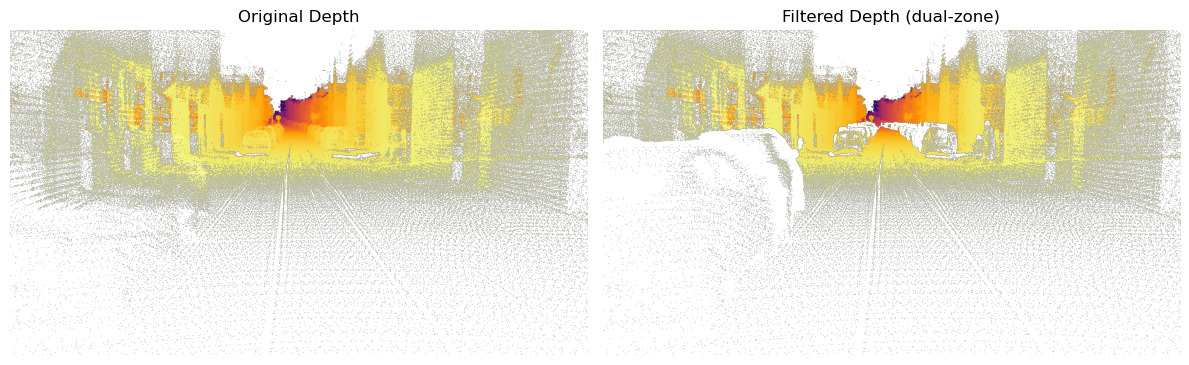

/tmp/ipykernel_181369/1786802827.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


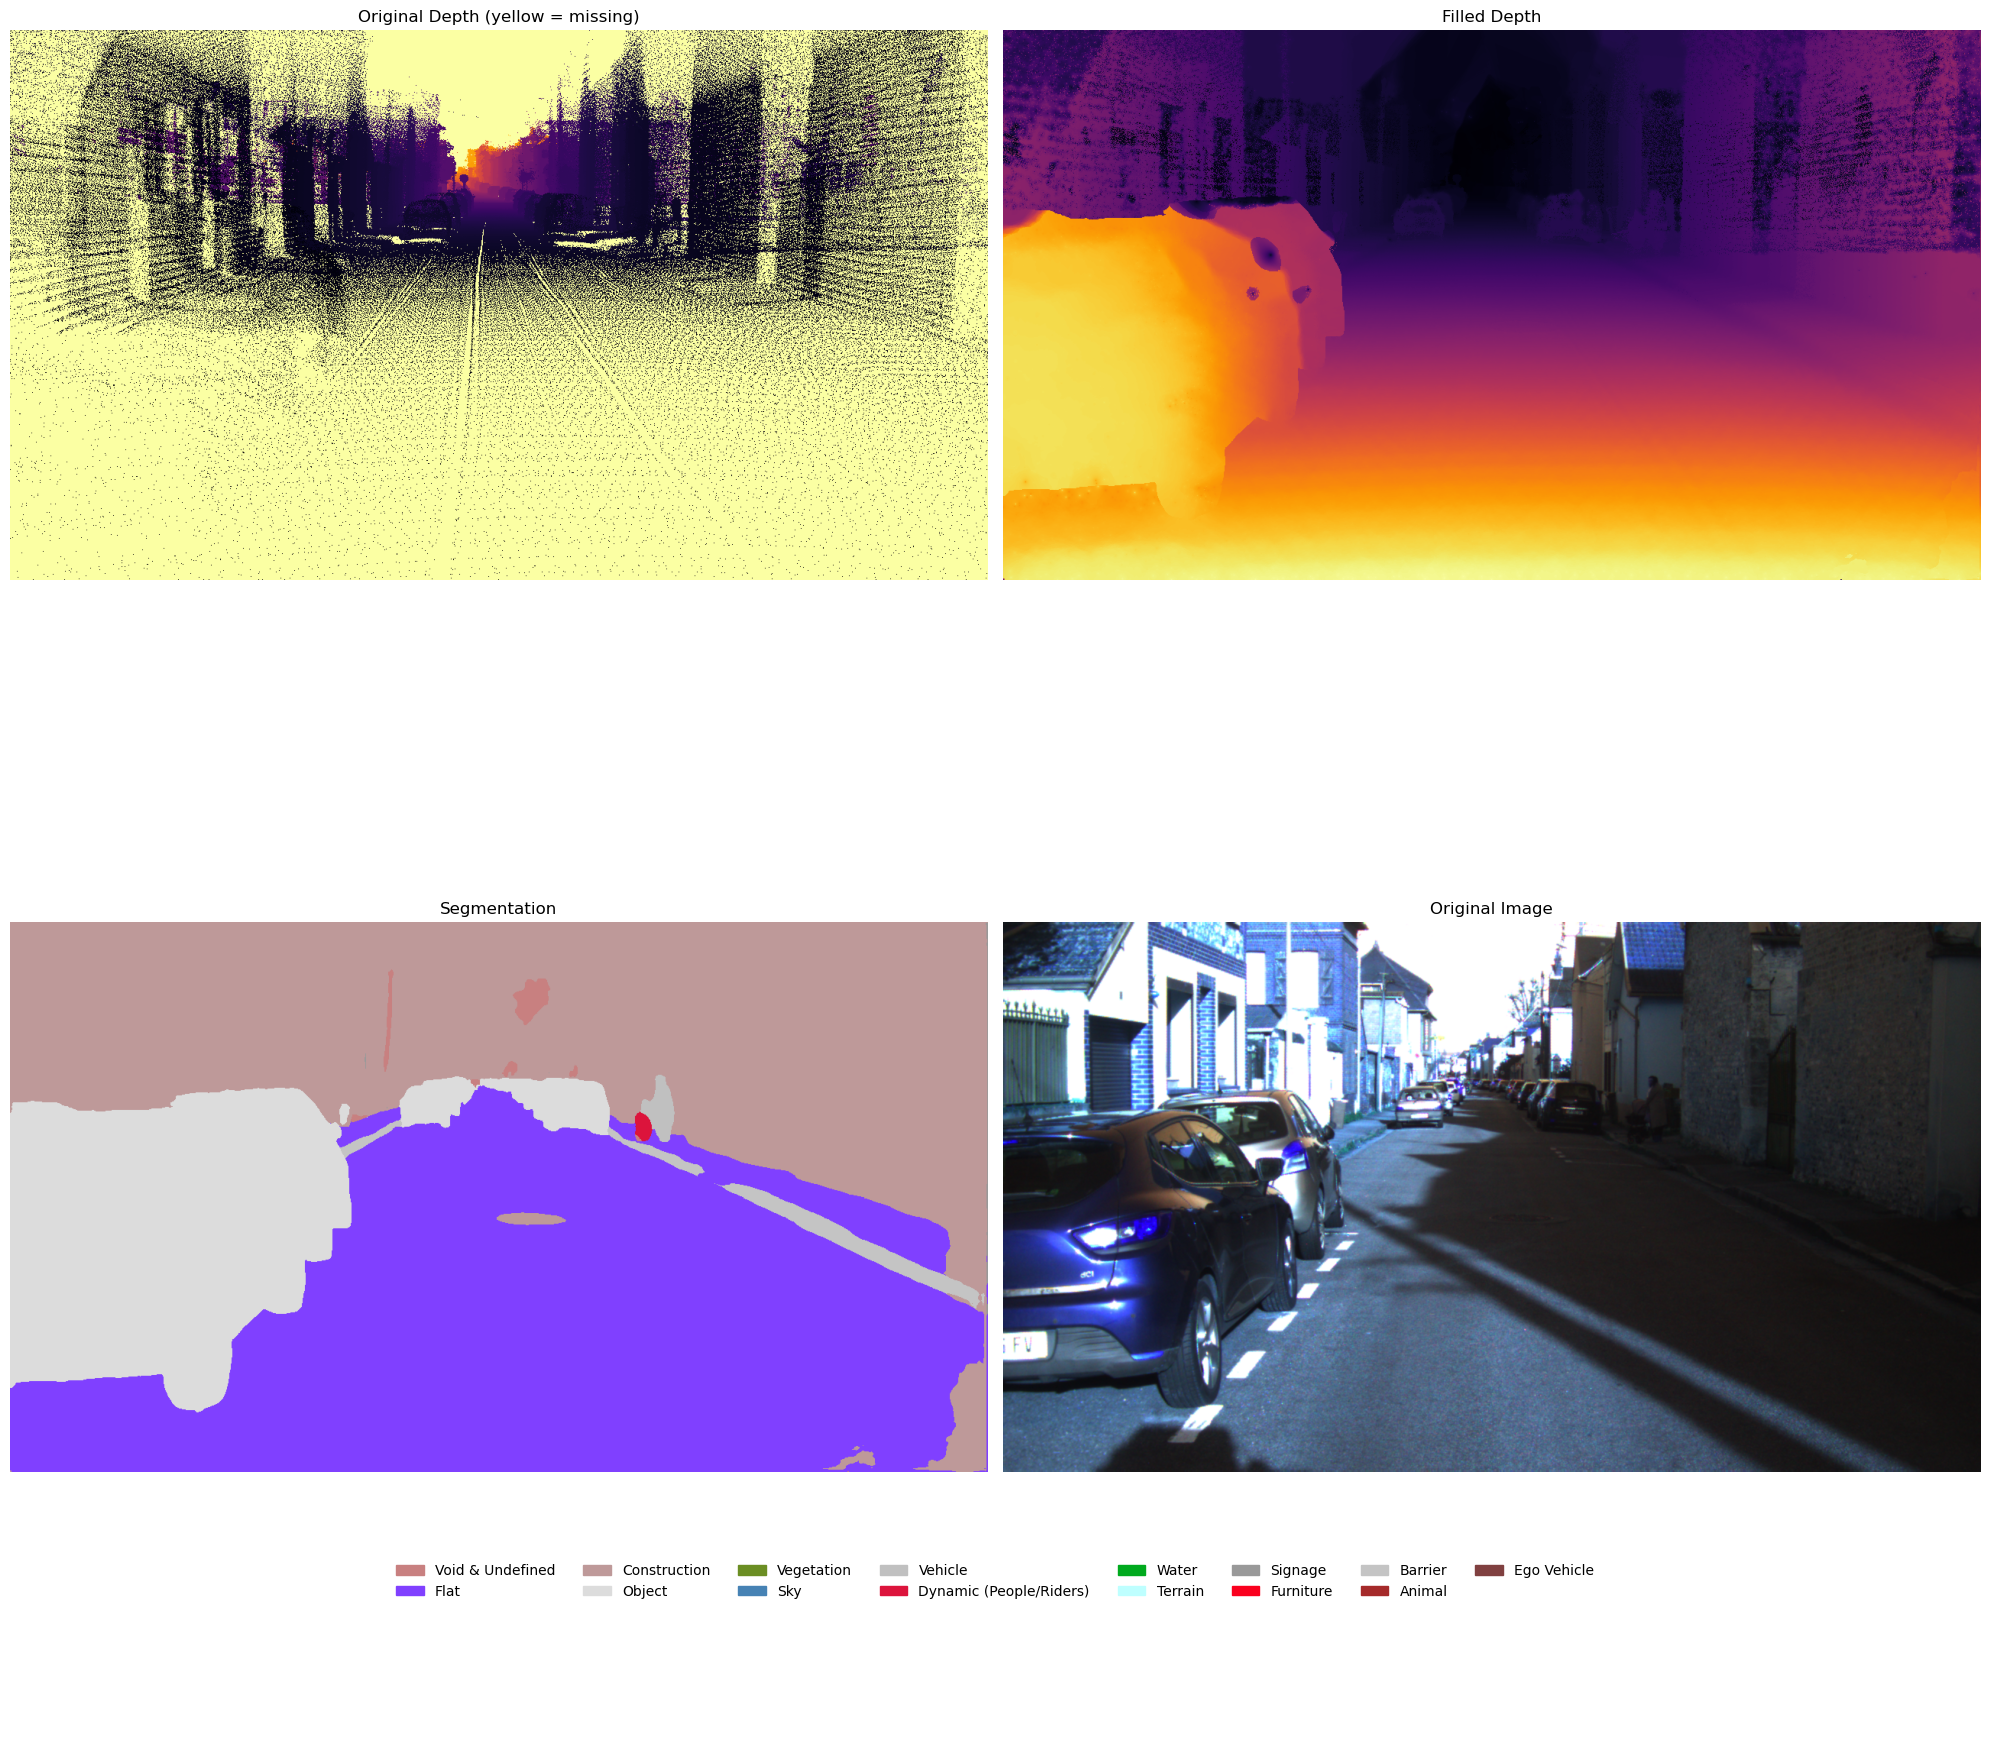

Depth map completion statistics:
  Total pixels: 921600
  Missing pixels before: 650503 (70.58%)
  Missing pixels after: 1 (0.00%)
  Completion rate: 100.00%


In [1817]:
image_number = 68

# Format string paths using the image number
instance_image_path = f"./seg_map/seg_map_{image_number}.png"
depth_image_path = f"./res/depth_map_{image_number}.png"
depth_npy_path = f"./res_npy/depth_map_{image_number}.npy"
segmentation_image_path = f"./seg_map/seg_map_{image_number}.png"
original_image = cv2.imread(f'./images1/{image_number}.png')
print("Existe :", os.path.exists(segmentation_image_path))
# Test different filling methods
#methods = ['semantic_joint', 'knn', 'knn_connected', 'knn_min', 'simple_vote','median', 'mean', 'gaussian','linear_interp', 'cubic_interp', 'nearest_interp', 'hdbscan','min', 'max', 'vote', 'knn_connected', 'knn_min', 'simple_vote']
methods=["semantic_joint"]
results = {}

for method in methods:
        print(f"\n{'='*80}\nProcessing with {method.upper()} method\n{'='*80}")
        
        # Process with current method
        depth_map, filled_depth, segmentation_map, stats = process_depth_with_segmentation(instance_image_path, original_image,
            depth_image_path,depth_npy_path ,segmentation_image_path, method=method
        )

        # Store results
        results[method] = {
            'filled_depth': filled_depth,
            'stats': stats
        }

        # Print statistics for each class
        #print(f"\nDepth statistics by class (method: {method}):")
        '''for class_name, class_stats in stats.items():
            print(f"Class: {class_name}")
            for stat_name, stat_value in class_stats.items():
                print(f"  {stat_name}: {stat_value}")
            print("-" * 50)
'''
        # Save filled depth map
        plt.imsave(f"filled_depth_{method}.png", filled_depth, cmap='inferno')

    # Compare methods
#print("\n\nComparison of filling methods:")
#print(f"{'Class':<20} {'Method':<10} {'Mean':<10} {'Median':<10} {'Std':<10}")
#print("-" * 1000)

# Get unique class names across all methods
all_classes = set()
for method_stats in [results[method]['stats'] for method in methods]:
        all_classes.update(method_stats.keys())

    # Compare statistics for each class
for class_name in sorted(all_classes):
        #print(f"{class_name:<20}")
        for method in methods:
            if class_name in results[method]['stats']:
                stats = results[method]['stats'][class_name]
                mean_val = stats['mean'] if stats['mean'] is not None else 'N/A'
                median_val = stats['median'] if stats['median'] is not None else 'N/A'
                std_val = stats['std'] if stats['std'] is not None else 'N/A'

                if isinstance(mean_val, float):
                    mean_val = f"{mean_val:.4f}"
                if isinstance(median_val, float):
                    median_val = f"{median_val:.4f}"
                if isinstance(std_val, float):
                    std_val = f"{std_val:.4f}"

                #print(f"{'':<20} {method:<10} {mean_val:<10} {median_val:<10} {std_val:<10}")
        #print("-" * 1000)

In [1818]:
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter
def smooth_depth_with_guided_segmentation(filled_depth, segmentation_map, sigma_spatial=5, sigma_depth=1.0):
    """
    Smooth depth using segmentation guidance without creating visible borders.

    Args:
        filled_depth (H, W): Input depth map with missing values filled.
        segmentation_map (H, W): Segmentation map with class labels.
        sigma_spatial (int): Gaussian smoothing kernel size (in pixel space).
        sigma_depth (float): Weight for penalizing depth differences.

    Returns:
        Smoothed depth map (H, W)
    """
    smoothed_depth = np.zeros_like(filled_depth)
    confidence = np.zeros_like(filled_depth)

    unique_classes = np.unique(segmentation_map)

    for class_id in unique_classes:
        if class_id == 255:  # ignore void
            continue
        class_mask = (segmentation_map == class_id).astype(np.float32)
        depth_masked = filled_depth * class_mask

        # Use Gaussian filtering, but apply only within the class
        blurred = gaussian_filter(depth_masked, sigma=sigma_spatial)
        blurred_mask = gaussian_filter(class_mask, sigma=sigma_spatial)

        # Avoid division by zero
        class_depth = np.divide(blurred, blurred_mask + 1e-5)

        # Combine depth values
        smoothed_depth += class_depth * class_mask
        confidence += class_mask

    # Normalize by confidence (number of contributions per pixel)
    smoothed_depth = np.divide(smoothed_depth, confidence + 1e-5)
    return smoothed_depth




In [1819]:
def smooth_depth_connected_objects_blend(filled_depth, segmentation_map, radius=50, blend_width=10):
    depth_smooth = filled_depth.copy()
    height, width = filled_depth.shape
    unique_classes = np.unique(segmentation_map)

    # Create an empty map to accumulate weighted depth and weights for blending
    depth_accum = np.zeros_like(filled_depth, dtype=np.float32)
    weight_accum = np.zeros_like(filled_depth, dtype=np.float32)

    for class_id in unique_classes:
        if class_id == 255:
            continue
        class_mask = (segmentation_map == class_id).astype(np.uint8)
        num_labels, labels_map, stats, _ = cv2.connectedComponentsWithStats(class_mask, connectivity=4)

        # Dilate the object mask to create blending region
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (blend_width*2+1, blend_width*2+1))

        for label_idx in range(1, num_labels):
            obj_mask = (labels_map == label_idx).astype(np.uint8)
            if obj_mask.sum() == 0:
                continue

            # Dilate mask for blending edges
            dilated_mask = cv2.dilate(obj_mask, kernel)

            # Compute soft blending weights: distance to object inside the dilation
            dist_to_obj = cv2.distanceTransform(1 - obj_mask, cv2.DIST_L2, 3)
            weights = np.clip(1 - dist_to_obj / blend_width, 0, 1) * dilated_mask

            ys, xs = np.where(dilated_mask > 0)
            for y, x in zip(ys, xs):
                local_weights = weights[max(0,y-radius):y+radius+1, max(0,x-radius):x+radius+1]
                local_depths = filled_depth[max(0,y-radius):y+radius+1, max(0,x-radius):x+radius+1]

                w_sum = np.sum(local_weights)
                if w_sum > 0:
                    depth_val = np.sum(local_depths * local_weights) / w_sum
                    depth_accum[y, x] += depth_val * local_weights[radius, radius]
                    weight_accum[y, x] += local_weights[radius, radius]

    # Normalize accumulated depth by weights
    valid = weight_accum > 0
    depth_smooth[valid] = depth_accum[valid] / weight_accum[valid]

    return depth_smooth

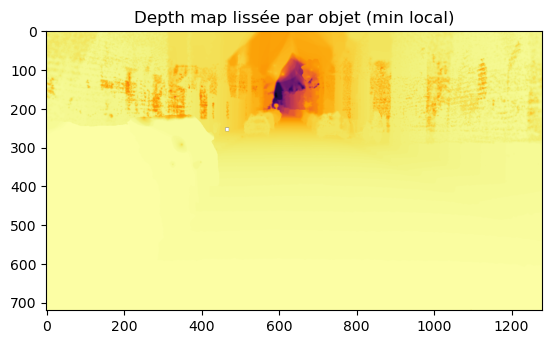

In [1820]:
#baseline=0.4622
#focale=0.009522

#filled_depth = ((baseline*focale)/filled_depth) # Convert to depth in meters

#plt.imshow(filled_depth, cmap='inferno',)

#depth_smooth = smooth_depth_connected_objects(filled_depth, segmentation_map, radius=50)
depth_smooth =smooth_depth_with_guided_segmentation(filled_depth, segmentation_map, sigma_spatial=1,sigma_depth=0.5)
#depth_smooth = smooth_depth_connected_objects_blend(filled_depth, segmentation_map, radius=5,  blend_width=3)
plt.imshow(depth_smooth, cmap='inferno_r')
plt.title("Depth map lissée par objet (min local)")
plt.show()
#plt.imsave(os.path.join("smooth_filled_disparity", "800.png"), depth_smooth, cmap='inferno')

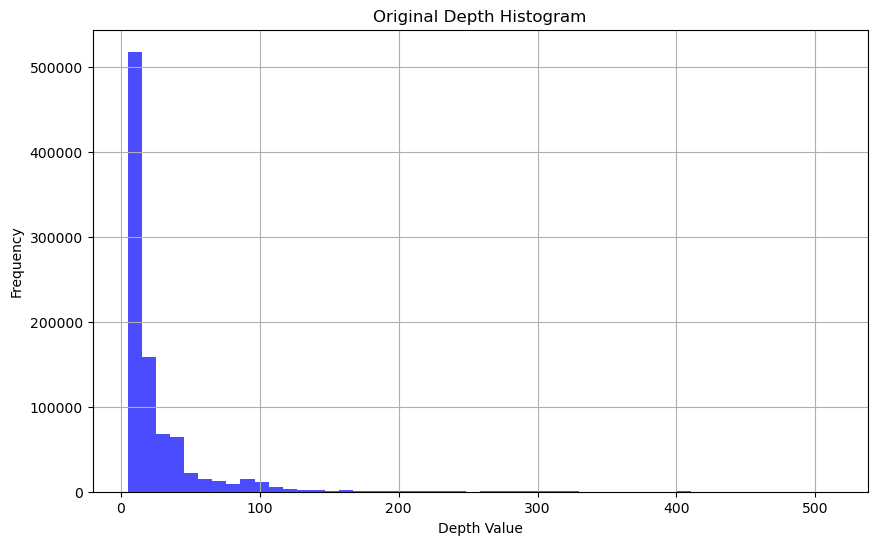

(720, 1280)
90.823006


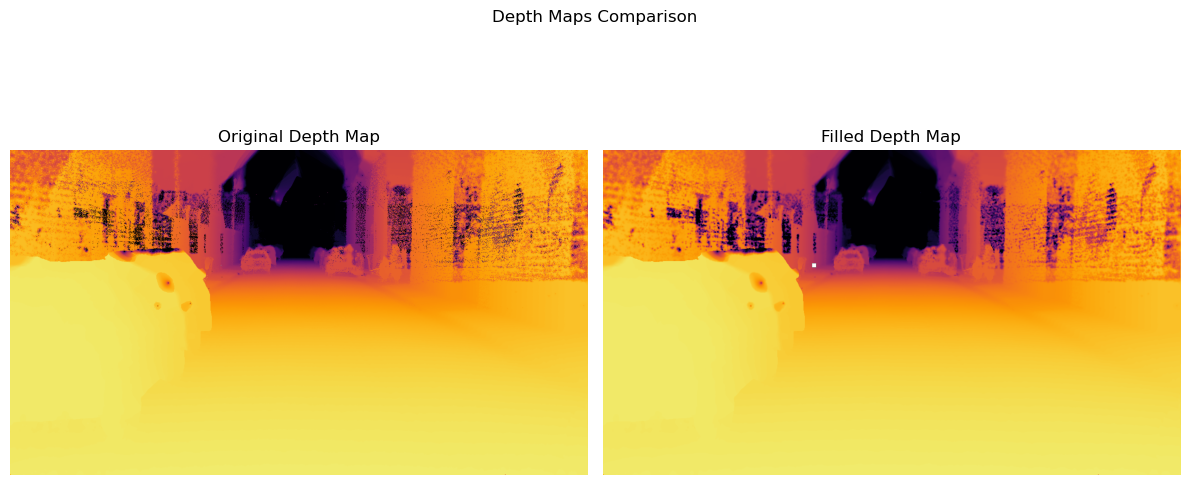

In [1821]:
# showing the histogram of the original depth map
def plot_depth_histogram(depth_map, title="Depth Histogram"):
    """
    Plot histogram of depth values in the depth map.

    Args:
        depth_map: 2D depth map (H, W)
        title: Title for the histogram plot
    """
    plt.figure(figsize=(10, 6))
    plt.hist(filled_depth[~np.isnan(depth_map)].flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel('Depth Value')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()
plot_depth_histogram(depth_smooth, title="Original Depth Histogram")
print(depth_map.shape)
# plot the depth map and the filled depth map
def plot_depth_maps(original_depth, filled_depth, title="Depth Maps Comparison"):
    """
    Plot original and filled depth maps side by side.

    Args:
        original_depth: Original depth map (H, W)
        filled_depth: Filled depth map (H, W)
        title: Title for the plot
    """
    percentile=95
    # Normalize depth maps for better visualization
    vmax = np.nanpercentile(original_depth, percentile)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    #plt.imshow(original_depth, cmap='inferno',vmin=-0.00005, vmax=0.00060) # Adjust vmin/vmax as needed
    plt.imshow(original_depth,cmap='inferno_r',vmin=0,vmax=vmax) # Adjust vmin/vmax as needed
    plt.title('Original Depth Map')
    '''plt.imsave(os.path.join("filled_disparity", "1100.png"), original_depth, cmap='inferno'
               , vmin=0, vmax=vmax)'''
    plt.axis('off')

    plt.subplot(1, 2, 2)
    #plt.imshow(filled_depth, cmap='inferno', vmin=-0.00005, vmax=0.00060) # Adjust vmin/vmax as needed
    plt.imshow(depth_smooth, cmap='inferno_r',vmin=0,vmax=vmax) # Adjust vmin/vmax as needed
    print(vmax)
    plt.title('Filled Depth Map')
    ''' plt.imsave(os.path.join("disp", "smooth_depth_1100.png"), depth_smooth, cmap='inferno',vmin=0,vmax=vmax)'''
    plt.axis('off')


    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    disparity_map=np.zeros_like(filled_depth)
    baseline = 0.4662  # in meters
    focale = 1685.87019   # in pixels
    #focale = 0.009 # Baseline in meters (example value)
#filled_depth = 1-filled_depth /255  # Normalize depth to [0, 1]
plot_depth_maps(filled_depth, filled_depth, title="Depth Maps Comparison")
#print("unique values in depth map:", np.unique(depth_map))

### Pipeline for handling all the images in ./images ./seg_map ./res matching together
#### then downloading the filled depth and the smooth filled in the corresponding folders
#### for filled map we are using the knn algorithm with k=50 and for smoothing
#### we are using the smothing algorithm also with a raduis=50

In [1822]:
'''import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.neighbors import KNeighborsRegressor

# Créer les dossiers de sortie s'ils n'existent pas
os.makedirs("filled_disparity", exist_ok=True)
os.makedirs("smooth_filled_disparity", exist_ok=True)

# Obtenir la liste des fichiers segmentation dans seg_map
seg_files = glob.glob("./seg_map/seg_map_*.png")
print(f"Trouvé {len(seg_files)} fichiers de segmentation dans le dossier seg_map")

# Pour chaque fichier de segmentation, vérifier s'il existe une image de profondeur correspondante
processed_count = 0
skipped_count = 0

for seg_file in seg_files:
    # Extraire le numéro de l'image depuis le nom du fichier
    base_name = os.path.basename(seg_file)
    image_number = base_name.replace("seg_map_", "").replace(".png", "")

    # Construire les chemins des fichiers correspondants et de sortie
    depth_file = f"./res/depth_map_{image_number}.png"
    original_image_file = f"./images1/{image_number}.png"
    output_file_1 = f"filled_disparity/{image_number}.png"
    output_file_2 = f"smooth_filled_disparity/{image_number}.png"

    # Vérifier si les fichiers de sortie existent déjà, si oui, sauter cette image
    if os.path.exists(output_file_1) and os.path.exists(output_file_2):
        print(f"Les fichiers de sortie pour l'image {image_number} existent déjà. Ignoré.")
        skipped_count += 1
        continue

    # Vérifier si les fichiers correspondants existent
    if not os.path.exists(depth_file):
        print(f"Image de profondeur non trouvée pour {base_name}. Ignoré.")
        continue

    if not os.path.exists(original_image_file):
        print(f"Image originale non trouvée pour {base_name}. Ignoré.")
        continue

    # Charger l'image originale
    original_image = cv2.imread(original_image_file)
    if original_image is None:
        print(f"Erreur lors de la lecture de l'image originale {original_image_file}. Ignoré.")
        continue

    print(f"Traitement de l'image {image_number}...")

    # Traiter l'image avec la méthode KNN
    method = 'knn'
    depth_map, filled_depth, segmentation_map, stats = process_depth_with_segmentation(
        seg_file,
        original_image,
        depth_file,
        seg_file,
        method=method
    )

    # Appliquer le lissage par objet
    depth_smooth = smooth_depth_connected_objects(filled_depth, segmentation_map, radius=50)

    # Déterminer la valeur max pour la normalisation
    percentile = 85
    vmax = np.nanpercentile(filled_depth, percentile)

    # Sauvegarder le résultat final
    plt.imsave(output_file_1, filled_depth, cmap='inferno', vmin=0, vmax=vmax)
    plt.imsave(output_file_2, depth_smooth, cmap='inferno', vmin=0, vmax=vmax)

    processed_count += 1
    print(f"Image {image_number} traitée et sauvegardée sous {output_file_2}")

print(f"\nTraitement terminé. {processed_count} images ont été traitées avec succès.")
print(f"{skipped_count} images ont été ignorées car déjà traitées.")'''

'import os\nimport glob\nimport cv2\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom collections import defaultdict\nfrom sklearn.neighbors import KNeighborsRegressor\n\n# Créer les dossiers de sortie s\'ils n\'existent pas\nos.makedirs("filled_disparity", exist_ok=True)\nos.makedirs("smooth_filled_disparity", exist_ok=True)\n\n# Obtenir la liste des fichiers segmentation dans seg_map\nseg_files = glob.glob("./seg_map/seg_map_*.png")\nprint(f"Trouvé {len(seg_files)} fichiers de segmentation dans le dossier seg_map")\n\n# Pour chaque fichier de segmentation, vérifier s\'il existe une image de profondeur correspondante\nprocessed_count = 0\nskipped_count = 0\n\nfor seg_file in seg_files:\n    # Extraire le numéro de l\'image depuis le nom du fichier\n    base_name = os.path.basename(seg_file)\n    image_number = base_name.replace("seg_map_", "").replace(".png", "")\n\n    # Construire les chemins des fichiers correspondants et de sortie\n    depth_file = f"./res/depth_map_{imag